# FIFA World Cup Data Exploration

In this notebook, we'll explore the dataset previously cleaned to try and identify features that can help us predict a match outcome. First, we should import the packages that will be used to analyse the data.

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns

sns.set(rc={'figure.figsize':(8, 6)})

## Datasets

Let's import the datasets we have already cleaned and treated. At first, we're gonna look at the data in the _matches_ database, since it less general.

In [2]:
matches = pd.read_csv('data/WorldCupMatches_clean.csv')
players = pd.read_csv('data/WorldCupPlayers_clean.csv')
world_cups = pd.read_csv('data/WorldCups_clean.csv')

In [3]:
matches.head()

,Year,Datetime,Stage,Stadium,City,Home Team Name,Home Team Goals,Away Team Goals,Away Team Name,Win conditions,Attendance,Half-time Home Goals,Half-time Away Goals,Referee,Assistant 1,Assistant 2,RoundID,MatchID,Home Team Initials,Away Team Initials
0,1930.0,13 Jul 1930 - 15:00,Group 1,Pocitos,Montevideo,France,4.0,1.0,Mexico,,4444.0,3.0,0.0,LOMBARDI Domingo (URU),CRISTOPHE Henry (BEL),REGO Gilberto (BRA),201.0,1096.0,FRA,MEX
1,1930.0,13 Jul 1930 - 15:00,Group 4,Parque Central,Montevideo,USA,3.0,0.0,Belgium,,18346.0,2.0,0.0,MACIAS Jose (ARG),MATEUCCI Francisco (URU),WARNKEN Alberto (CHI),201.0,1090.0,USA,BEL
2,1930.0,14 Jul 1930 - 12:45,Group 2,Parque Central,Montevideo,Yugoslavia,2.0,1.0,Brazil,,24059.0,2.0,0.0,TEJADA Anibal (URU),VALLARINO Ricardo (URU),BALWAY Thomas (FRA),201.0,1093.0,YUG,BRA
3,1930.0,14 Jul 1930 - 14:50,Group 3,Pocitos,Montevideo,Romania,3.0,1.0,Peru,,2549.0,1.0,0.0,WARNKEN Alberto (CHI),LANGENUS Jean (BEL),MATEUCCI Francisco (URU),201.0,1098.0,ROU,PER
4,1930.0,15 Jul 1930 - 16:00,Group 1,Parque Central,Montevideo,Argentina,1.0,0.0,France,,23409.0,0.0,0.0,REGO Gilberto (BRA),SAUCEDO Ulises (BOL),RADULESCU Constantin (ROU),201.0,1085.0,ARG,FRA


Looking at the info present in _matches_, we can see that a few columns do not (or, at least, should not) interfere in the match outcome. Let's drop those columns.

In [4]:
matches.drop(columns=['Stadium', 'City', 'Attendance', 'Referee', 'Assistant 1', 'Assistant 2'], inplace=True)

Also, to facilitate data filtering, let's remove those whitespaces form the column's names and replace the string values on column _Datetime_ to the corresponding _Timestamp_ objects.

In [5]:
matches.columns = [re.sub(r'[\s\-]', '_', col) for col in matches.columns]
matches.Datetime = pd.to_datetime(matches.Datetime)

## Home vs Away

Let's analyse if there is any correlation between a team being the "match host" (Home Team) and the match result. We will use the following method to identify the match winners.

In [6]:
def who_won(s):
    """Method to retrieve initials of match winner"""
    penalty_score_pattern = re.compile(r'\(\s*(\d+)\s*\-\s*(\d+)\s*\)')
    
    # Winner during regular time
    if s.Home_Team_Goals > s.Away_Team_Goals:
        return s.Home_Team_Initials
    elif s.Home_Team_Goals < s.Away_Team_Goals:
        return s.Away_Team_Initials
    
    # Winner during extra time or penalties
    if s.Home_Team_Name in s.Win_conditions.strip():
        return s.Home_Team_Initials
    if s.Away_Team_Name in s.Win_conditions.strip():
        return s.Away_Team_Initials
    
    # Winner during penalties (no name in win conditions)
    match = penalty_score_pattern.search(s.Win_conditions)
    if match is not None:
        home_penalties, away_penalties = map(int, match.groups())
        if home_penalties > away_penalties:
            return s.Home_Team_Initials
        if home_penalties < away_penalties:
            return s.Away_Team_Initials
    
    return '-'

def home_away_won(s):
    """Method to retrieve if match winner was home or away team"""
    if s.Winner_Initials == '-':
        return '-'
    
    return 'Home' if s.Winner_Initials == s.Home_Team_Initials else 'Away'

In [7]:
matches['Winner_Initials'] = matches.apply(who_won, axis=1)
matches['Home_Away_Winner'] = matches.apply(home_away_won, axis=1)

Since the choice of being home or away team does not reflect to where the match will be held, this distribution of wins between Home and Away teams should be similar. However, that's not true, as the figure below shows.

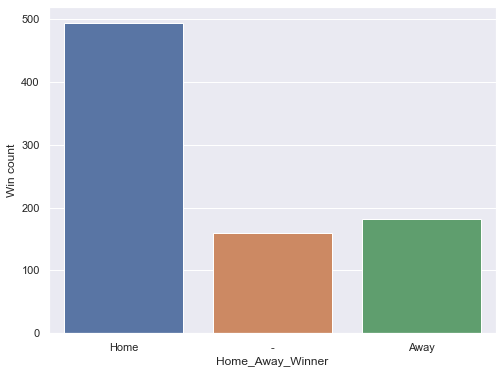

In [8]:
sns.countplot(x='Home_Away_Winner', data=matches)
plt.ylabel('Win count')
plt.show()

If we observe this distribution accross the editions we see that the distribution is more similar on the recent editions than the first ones. However, it still seems that home teams have a little advantage over away teams.

This could be explained by how FIFA arrange the teams. Usually, well-ranked teams are more likely to be labeled as the home team of a match, justifying the distribution.

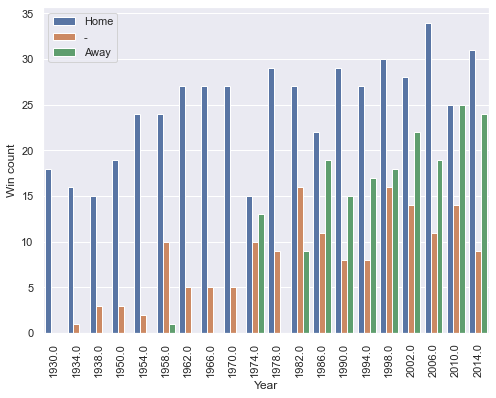

In [9]:
sns.countplot(x='Year', data=matches, hue='Home_Away_Winner')
plt.xticks(rotation=90)
plt.ylabel('Win count')
plt.legend(loc=2)
plt.show()

## Momentum

Another feature that may influence the outcome of a match is the momentum of each team. The momentum describes how was the performance of a given team on the previous _n_ matches.

To calculate the momentum, we'll only consider the previous 5 matches of a team. We will use two different strategies to calculate the momentum for further comparison:

* Plus-minus strategy: a victory is awarded +1 points, a draw is awarded 0 points and a loss is awarded -1 points.
* Three points strategy: a victory is awarded 3 points, a draw is awarded 1 point for each team and a loss is awarded 0 points.

These strategies will be declared in dictionary format, as show below:

In [10]:
plus_minus_strategy = {'win': 1, 'draw': 0, 'loss': -1}
three_points_strategy = {'win': 3, 'draw': 1, 'loss': 0}

The method to calculate the team momentum in a given match is given by:

In [11]:
def team_momentum(team_initials: str, date: pd.Timestamp, matches: pd.DataFrame,
                  strategy: dict = plus_minus_strategy, window: int = 5) -> int:
    """Method to calculate a team momentum in a given window"""
    
    team_matches = matches[
        (matches.Home_Team_Initials == team_initials) |
        (matches.Away_Team_Initials == team_initials)
    ]
    
    team_prev_matches = team_matches[team_matches.Datetime < date].sort_values(by='Datetime').tail(window)
    
    momentum = 0
    for match in team_prev_matches.itertuples():
        if match.Winner_Initials == '-':
            momentum += strategy.get('draw', 0)
        elif match.Winner_Initials == team_initials:
            momentum += strategy.get('win', 1)
        else:
            momentum += strategy.get('loss', -1)
    
    return momentum    

In order to test our _team_momentum_ method, let's grab a random match in our dataset.

In [12]:
dt = matches.sample(random_state=13)
dt

,Year,Datetime,Stage,Home_Team_Name,Home_Team_Goals,Away_Team_Goals,Away_Team_Name,Win_conditions,Half_time_Home_Goals,Half_time_Away_Goals,RoundID,MatchID,Home_Team_Initials,Away_Team_Initials,Winner_Initials,Home_Away_Winner
159,1962.0,1962-06-07 15:00:00,Group 2,Italy,3.0,0.0,Switzerland,,1.0,0.0,231.0,1532.0,ITA,SUI,ITA,Home


Looking at Italy's previous five matches, we see that they lost 3, draw 1 and won 1. That should gives them a momentum of -2 (_plus minus strategy_) and 4 (_three points strategy_).

In [13]:
initials = dt.iloc[0]['Winner_Initials']
date = dt.iloc[0]['Datetime']

matches[
    ((matches.Home_Team_Initials == initials) |
     (matches.Away_Team_Initials == initials)) &
    (matches.Datetime < date)
].sort_values(by='Datetime').tail()

,Year,Datetime,Stage,Home_Team_Name,Home_Team_Goals,Away_Team_Goals,Away_Team_Name,Win_conditions,Half_time_Home_Goals,Half_time_Away_Goals,RoundID,MatchID,Home_Team_Initials,Away_Team_Initials,Winner_Initials,Home_Away_Winner
82,1954.0,1954-06-17 17:50:00,Group 4,Switzerland,2.0,1.0,Italy,,1.0,1.0,211.0,1300.0,SUI,ITA,SUI,Home
90,1954.0,1954-06-20 17:00:00,Group 4,Italy,4.0,1.0,Belgium,,1.0,0.0,211.0,1243.0,ITA,BEL,ITA,Home
92,1954.0,1954-06-23 18:00:00,Group 4,Switzerland,4.0,1.0,Italy,,1.0,0.0,211.0,1301.0,SUI,ITA,SUI,Home
143,1962.0,1962-05-31 15:00:00,Group 2,Germany FR,0.0,0.0,Italy,,0.0,0.0,231.0,1507.0,FRG,ITA,-,-
147,1962.0,1962-06-02 15:00:00,Group 2,Chile,2.0,0.0,Italy,,0.0,0.0,231.0,1472.0,CHI,ITA,CHI,Home


In [14]:
print('Momentum (plus-minus strategy):', team_momentum(initials, date, matches, strategy=plus_minus_strategy))
print('Momentum (three points strategy):', team_momentum(initials, date, matches, strategy=three_points_strategy))

Momentum (plus-minus strategy): -2
Momentum (three points strategy): 4


Great! That's exactly what our method is returning to us!

Now we can calculate the momentum of all teams and the momentum difference between home and away teams for all matches.

In [77]:
matches['Home_Team_Momentum_pm'] = matches.apply(lambda s: team_momentum(s.Home_Team_Initials, s.Datetime, matches, strategy=plus_minus_strategy), axis=1)
matches['Away_Team_Momentum_pm'] = matches.apply(lambda s: team_momentum(s.Away_Team_Initials, s.Datetime, matches, strategy=plus_minus_strategy), axis=1)
matches['Diff_Momentum_pm'] = matches['Home_Team_Momentum_pm'] - matches['Away_Team_Momentum_pm']

matches['Home_Team_Momentum_3p'] = matches.apply(lambda s: team_momentum(s.Home_Team_Initials, s.Datetime, matches, strategy=three_points_strategy), axis=1)
matches['Away_Team_Momentum_3p'] = matches.apply(lambda s: team_momentum(s.Away_Team_Initials, s.Datetime, matches, strategy=three_points_strategy), axis=1)
matches['Diff_Momentum_3p'] = matches['Home_Team_Momentum_3p'] - matches['Away_Team_Momentum_3p']

# matches.sort_values('Datetime')

Now we can have a look at the distribution of the differences and see if it has any connection with the outcome of the matches. If they do have, we should expect that:

* Matches with a high value of `Diff_Momentum` resulted mostly on home teams winning;
* Likewise, matches with ver negative values of `Diff_Momentum` resulted mostly on away teams winning; and
* Most ties occurred when `Diff_Momentum` was close to 0.

Below, it is plotted the distributions of the difference for both strategies.

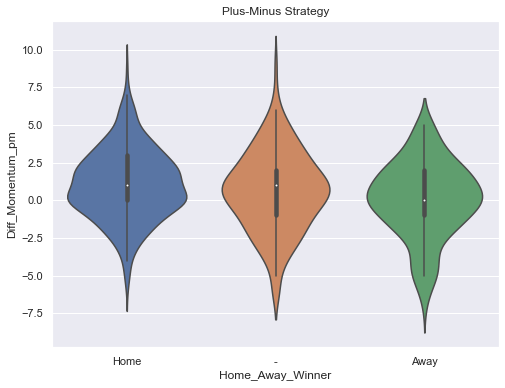

In [86]:
sns.violinplot(x='Home_Away_Winner', y='Diff_Momentum_pm', data=matches)
plt.title('Plus-Minus Strategy')
plt.show()

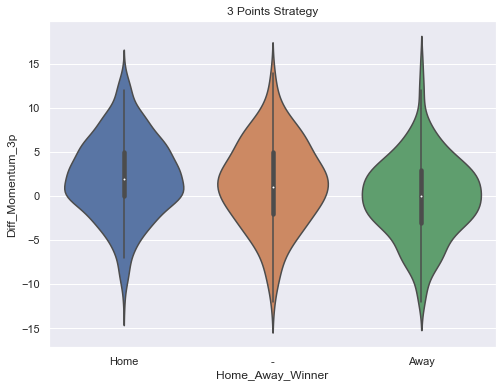

In [87]:
sns.violinplot(x='Home_Away_Winner', y='Diff_Momentum_3p', data=matches)
plt.title('3 Points Strategy')
plt.show()

Looks like the difference in the momentum of teams cannot be linked to the match result, since the distributions for each possible outcome are fairly similar. Thus, we can abandon the idea of using momentum as a feature.